# Calculate molecular size

In this example, we show how to go from a smiles string to the molecular size described in the manuscript.

Requirements to run this script:
* rdkit (2019.09.2.0)
* matplotlib (3.1.1)
* numpy (1.17.4)
* psp_source
    * Clone source code and run this notebook in its default directory.

### Provide SMILES string of a molecule:

In [15]:
from rdkit.Chem import AllChem as rdkit
from rdkit.Chem import Descriptors
# Needed to show molecules
from rdkit.Chem.Draw import IPythonConsole 

In [16]:
smiles = 'CCCCCC'

In [17]:
# Read SMILES and add Hs
mol = rdkit.MolFromSmiles(smiles)
mol = rdkit.AddHs(mol)
MW = Descriptors.MolWt(mol)
if MW > 500:
    print(f'> molecule is very big (MW: {MW}) - caution!')

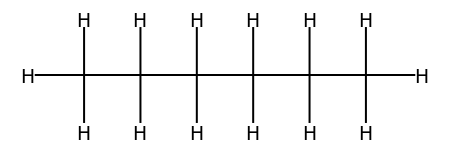

In [18]:
mol

### Produce N conformers:

In [24]:
# Produce 200 conformers using a random seed of 1000.
# A consistent random seed will produce consistent conformers.
cids = rdkit.EmbedMultipleConfs(
    mol=mol,
    numConfs=100,
    useExpTorsionAnglePrefs=True,
    useBasicKnowledge=True,
    randomSeed=1000
)
# UFF optimize each conformer.
for cid in cids:
    rdkit.UFFOptimizeMolecule(mol, confId=cid)

### Calculate molecular size:

In [25]:
# Handle directories.
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
import rdkit_functions

In [26]:
# Settings.
# Scale of vdw radii (paper uses: 0.9).
vdwScale = 0.9
# Margin of box (Angstrom) (paper uses: 4.0)
boxMargin = 4.0
# Grid spacing (Angstrom) (paper uses: 0.5)
spacing = 0.5
# Options to visualise/plot the final ellipsoid.
show_vdw = False
plot_ellip = False 
# Option to output the ellipsoid at each step.
do_step_plot = False

In [27]:
# Run calculations.
# Can take up to 5 minutes for large molecules.
results = rdkit_functions.get_ellip_diameters(
    mol,
    cids,
    vdwScale=vdwScale,
    boxMargin=boxMargin,
    spacing=spacing,
    show=show_vdw,
    plot=plot_ellip,
    do_step_plot=do_step_plot
)

In [33]:
conf_diameters, conf_axes, conf_moments = results
diam_1s = [sorted(i)[0] for i in conf_diameters]
diam_2s = [sorted(i)[1] for i in conf_diameters]
diam_3s = [sorted(i)[2] for i in conf_diameters]

print(f'minimum intermediate diameter of {smiles} is {round(min(diam_2s), 2)} Angstrom')

minimum intermediate diameter of CCCCCC is 5.26 Angstrom


100 100 100


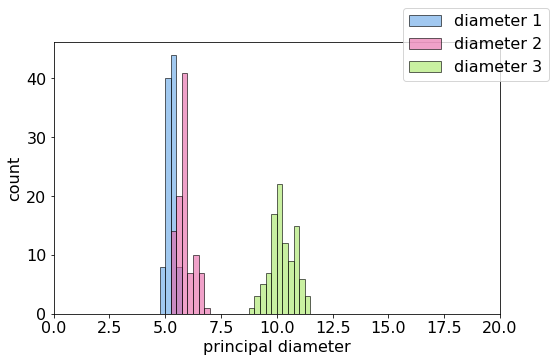

In [41]:
# Plot the conformer diameters.
import matplotlib.pyplot as plt
import plotting_fn as pfn
import numpy as np
print(len(diam_1s), len(diam_2s), len(diam_3s))

fig, ax = plt.subplots(figsize=(8, 5))
alpha = 0.6

width = 0.25

X_bins = np.arange(0, 20, width)

# First diameter.
hist, bin_edges = np.histogram(a=diam_1s, bins=X_bins)
ax.bar(
    bin_edges[:-1],
    hist,
    align='edge',
    alpha=alpha,
    width=width,
    color='#63A5E7',
    edgecolor='k',
    label='diameter 1'
)

# Intermediate diameter.
hist, bin_edges = np.histogram(a=diam_2s, bins=X_bins)
ax.bar(
    bin_edges[:-1],
    hist,
    align='edge',
    alpha=alpha,
    width=width,
    color='#E763A5',
    edgecolor='k',
    label='diameter 2'
)

# Largest diameter.
hist, bin_edges = np.histogram(a=diam_3s, bins=X_bins)
ax.bar(
    bin_edges[:-1],
    hist,
    align='edge',
    alpha=alpha,
    width=width,
    color='#A5E763',
    edgecolor='k',
    label='diameter 3'
)


pfn.define_standard_plot(
    ax,
    xtitle='principal diameter',
    ytitle='count',
    xlim=(0, 20),
    ylim=None
)
fig.legend(fontsize=16)

plt.show()